# Notebook for piNMF on an integrated dataset

## How to install 

### DOCKER PULL AND LAUNCH NOTEBOOK

docker pull juanmoriano/indirectneuro_jm:latest

docker run --name [CONTAINER_NAME] -e GRANT_SUDO=yes -e ROOT=TRUE -e PASSWORD="jupyter" -dit -p 9191:8888 -v [Volume_DATA] juanmoriano/indirectneuro_jm /bin/bash

docker exec -ti -u root [CONTAINER_NAME] bash

jupyter notebook --port=8888 --ip=0.0.0.0 --allow-root --no-browser

Work on NMF_indNeuro kernel - already present -

And make sure to work on directory containing FunctionalHALS.py SHALS.py piNMF.py -see below-

### Load packages

In [1]:
import scanpy as sc

import pandas as pd

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

In [2]:
%matplotlib inline

import os
from scipy.io import mmread

import scipy.sparse as sp
from IPython.display import Image

In [3]:
from piNMF import cNMF

### Create directory for saving data

### Clone repository 

### Copy python scripts into your working directory

## Preprocess data -- branch to oRG

In [30]:
adata = sc.read_h5ad("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/combined_count_all.h5ad")

In [31]:
milestones = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/scFates_output/combined_all_scFates_clustering.tsv", sep='\t', index_col=0)

In [32]:
adata.obs = pd.concat([adata.obs, milestones], axis=1)

In [33]:
cellembeddings = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/combined_all_cellembeddings.tsv", sep='\t')

In [34]:
cellembeddings.iloc[:,0] = cellembeddings.iloc[:,0]*-1 #for better geometry
cellembeddings.iloc[:,1] = cellembeddings.iloc[:,1]*-1 #for better geometry

In [35]:
adata.obsm['X_pca'] = cellembeddings.to_numpy() #sharing embeddings

In [36]:
adata.obs['PC_1'] = adata.obsm['X_pca'][:,0]
adata.obs['PC_2'] = adata.obsm['X_pca'][:,1]

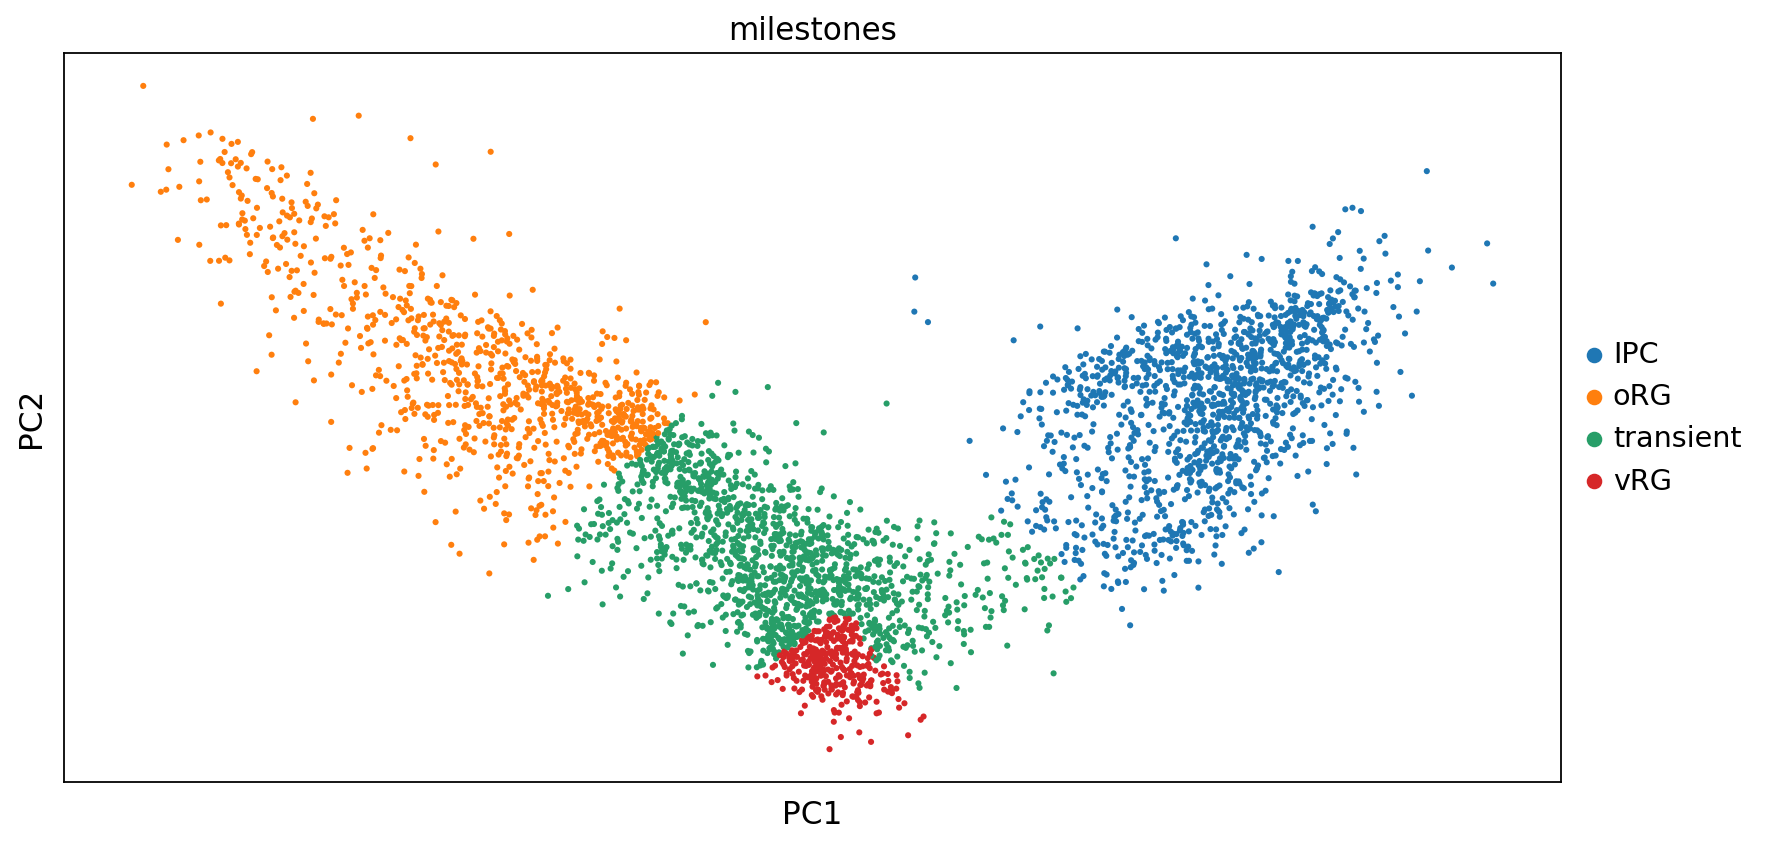

In [37]:
sc.pl.pca(adata, color = 'milestones')

In [38]:
adata.obs.columns

Index(['orig.ident', 'Sample.ID', 'Age', 'Batch', 'Cluster.Name', 'percent.mt',
       'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT',
       'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'sub.cluster',
       'integrated_snn_res.0.1', 'Cluster.Joint', 'milestones', 'seg', 't',
       'PC_1', 'PC_2'],
      dtype='object')

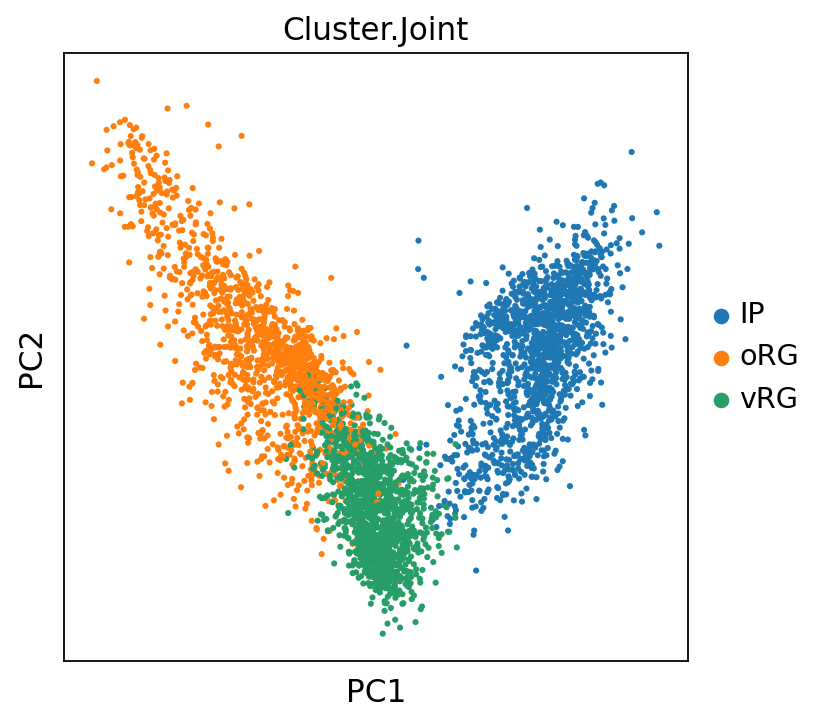

In [40]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.pca(adata, color = 'Cluster.Joint')

In [22]:
#RG: 3 and 2
branch_oRG = adata[(adata.obs['seg'] == 3) | (adata.obs['seg'] == 2),:]

In [23]:
branch_oRG

View of AnnData object with n_obs × n_vars = 2309 × 37818
    obs: 'orig.ident', 'Sample.ID', 'Age', 'Batch', 'Cluster.Name', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'sub.cluster', 'integrated_snn_res.0.1', 'Cluster.Joint', 'milestones', 'seg', 't', 'PC_1', 'PC_2'
    var: 'features'
    uns: 'milestones_colors'
    obsm: 'X_pca'

In [24]:
sc.pp.filter_genes(branch_oRG, min_cells=25)

sc.pp.highly_variable_genes(branch_oRG, n_top_genes=4000, flavor='seurat_v3')

branch_oRG = branch_oRG[:,branch_oRG.var['highly_variable'] == True].copy()

my_data = pd.DataFrame(branch_oRG.X.todense(), index=branch_oRG.obs['t'], columns=branch_oRG.var_names)

my_data.sort_index(inplace=True, ascending=True)

for_NMF = sc.AnnData(my_data)

for_NMF

#Including metadata to final object
branch_oRG.obs.index = branch_oRG.obs['t'].astype(np.float64)

branch_oRG.obs = branch_oRG.obs.reindex(np.sort(branch_oRG.obs.index))

for_NMF.obs.index = for_NMF.obs.index.astype(np.float64)

for_NMF.obs = for_NMF.obs.join(branch_oRG.obs)

/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/root/miniconda/envs/NMF_indNeuro/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0.093099799149227, 0.093179885992

In [25]:
for_NMF.write("/home/jovyan/jm_jlab/data_indNeuro/2.NMF/combined-all_vRGtooRG_4k.h5ad")

## Organize directories and set main parameters 

### Set path to data and output directory

In [8]:
numiter=  750 # Number of NMF replicates. Recommended ~200 for real data
numhvgenes= 4000 

countfn = '/home/jovyan/jm_jlab/data_indNeuro/2.NMF/combined-all_vRGtooRG_4k.h5ad'

## Results will be saved to [output_directory]/[run_name]
output_directory = '/home/jovyan/jm_jlab/jm_2023/combined-all_to_oRG/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'combined-all_to_oRG'

seed = 14

In [9]:
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [27]:
cnmf_obj.prepare(counts_fn=countfn, components=np.arange(3,7), n_iter=numiter, seed=seed, num_highvar_genes=numhvgenes)

In [28]:
cnmf_obj.factorize(worker_i=0, total_workers=1)

/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

[Worker 0]. Starting task 269.
[Worker 0]. Starting task 270.
[Worker 0]. Starting task 271.
[Worker 0]. Starting task 272.
[Worker 0]. Starting task 273.
[Worker 0]. Starting task 274.
[Worker 0]. Starting task 275.
[Worker 0]. Starting task 276.
[Worker 0]. Starting task 277.
[Worker 0]. Starting task 278.
[Worker 0]. Starting task 279.
[Worker 0]. Starting task 280.
[Worker 0]. Starting task 281.
[Worker 0]. Starting task 282.
[Worker 0]. Starting task 283.
[Worker 0]. Starting task 284.
[Worker 0]. Starting task 285.
[Worker 0]. Starting task 286.
[Worker 0]. Starting task 287.
[Worker 0]. Starting task 288.
[Worker 0]. Starting task 289.
[Worker 0]. Starting task 290.
[Worker 0]. Starting task 291.
[Worker 0]. Starting task 292.
[Worker 0]. Starting task 293.
[Worker 0]. Starting task 294.
[Worker 0]. Starting task 295.
[Worker 0]. Starting task 296.
[Worker 0]. Starting task 297.
[Worker 0]. Starting task 298.
[Worker 0]. Starting task 299.
[Worker 0]. Starting task 300.
[Worker 

[Worker 0]. Starting task 534.
[Worker 0]. Starting task 535.
[Worker 0]. Starting task 536.
[Worker 0]. Starting task 537.
[Worker 0]. Starting task 538.
[Worker 0]. Starting task 539.
[Worker 0]. Starting task 540.
[Worker 0]. Starting task 541.
[Worker 0]. Starting task 542.
[Worker 0]. Starting task 543.
[Worker 0]. Starting task 544.
[Worker 0]. Starting task 545.
[Worker 0]. Starting task 546.
[Worker 0]. Starting task 547.
[Worker 0]. Starting task 548.
[Worker 0]. Starting task 549.
[Worker 0]. Starting task 550.
[Worker 0]. Starting task 551.
[Worker 0]. Starting task 552.
[Worker 0]. Starting task 553.
[Worker 0]. Starting task 554.
[Worker 0]. Starting task 555.
[Worker 0]. Starting task 556.
[Worker 0]. Starting task 557.
[Worker 0]. Starting task 558.
[Worker 0]. Starting task 559.
[Worker 0]. Starting task 560.
[Worker 0]. Starting task 561.
[Worker 0]. Starting task 562.
[Worker 0]. Starting task 563.
[Worker 0]. Starting task 564.
[Worker 0]. Starting task 565.
[Worker 

[Worker 0]. Starting task 799.
[Worker 0]. Starting task 800.
[Worker 0]. Starting task 801.
[Worker 0]. Starting task 802.
[Worker 0]. Starting task 803.
[Worker 0]. Starting task 804.
[Worker 0]. Starting task 805.
[Worker 0]. Starting task 806.
[Worker 0]. Starting task 807.
[Worker 0]. Starting task 808.
[Worker 0]. Starting task 809.
[Worker 0]. Starting task 810.
[Worker 0]. Starting task 811.
[Worker 0]. Starting task 812.
[Worker 0]. Starting task 813.
[Worker 0]. Starting task 814.
[Worker 0]. Starting task 815.
[Worker 0]. Starting task 816.
[Worker 0]. Starting task 817.
[Worker 0]. Starting task 818.
[Worker 0]. Starting task 819.
[Worker 0]. Starting task 820.
[Worker 0]. Starting task 821.
[Worker 0]. Starting task 822.
[Worker 0]. Starting task 823.
[Worker 0]. Starting task 824.
[Worker 0]. Starting task 825.
[Worker 0]. Starting task 826.
[Worker 0]. Starting task 827.
[Worker 0]. Starting task 828.
[Worker 0]. Starting task 829.
[Worker 0]. Starting task 830.
[Worker 

[Worker 0]. Starting task 1062.
[Worker 0]. Starting task 1063.
[Worker 0]. Starting task 1064.
[Worker 0]. Starting task 1065.
[Worker 0]. Starting task 1066.
[Worker 0]. Starting task 1067.
[Worker 0]. Starting task 1068.
[Worker 0]. Starting task 1069.
[Worker 0]. Starting task 1070.
[Worker 0]. Starting task 1071.
[Worker 0]. Starting task 1072.
[Worker 0]. Starting task 1073.
[Worker 0]. Starting task 1074.
[Worker 0]. Starting task 1075.
[Worker 0]. Starting task 1076.
[Worker 0]. Starting task 1077.
[Worker 0]. Starting task 1078.
[Worker 0]. Starting task 1079.
[Worker 0]. Starting task 1080.
[Worker 0]. Starting task 1081.
[Worker 0]. Starting task 1082.
[Worker 0]. Starting task 1083.
[Worker 0]. Starting task 1084.
[Worker 0]. Starting task 1085.
[Worker 0]. Starting task 1086.
[Worker 0]. Starting task 1087.
[Worker 0]. Starting task 1088.
[Worker 0]. Starting task 1089.
[Worker 0]. Starting task 1090.
[Worker 0]. Starting task 1091.
[Worker 0]. Starting task 1092.
[Worker 

[Worker 0]. Starting task 1319.
[Worker 0]. Starting task 1320.
[Worker 0]. Starting task 1321.
[Worker 0]. Starting task 1322.
[Worker 0]. Starting task 1323.
[Worker 0]. Starting task 1324.
[Worker 0]. Starting task 1325.
[Worker 0]. Starting task 1326.
[Worker 0]. Starting task 1327.
[Worker 0]. Starting task 1328.
[Worker 0]. Starting task 1329.
[Worker 0]. Starting task 1330.
[Worker 0]. Starting task 1331.
[Worker 0]. Starting task 1332.
[Worker 0]. Starting task 1333.
[Worker 0]. Starting task 1334.
[Worker 0]. Starting task 1335.
[Worker 0]. Starting task 1336.
[Worker 0]. Starting task 1337.
[Worker 0]. Starting task 1338.
[Worker 0]. Starting task 1339.
[Worker 0]. Starting task 1340.
[Worker 0]. Starting task 1341.
[Worker 0]. Starting task 1342.
[Worker 0]. Starting task 1343.
[Worker 0]. Starting task 1344.
[Worker 0]. Starting task 1345.
[Worker 0]. Starting task 1346.
[Worker 0]. Starting task 1347.
[Worker 0]. Starting task 1348.
[Worker 0]. Starting task 1349.
[Worker 

[Worker 0]. Starting task 1576.
[Worker 0]. Starting task 1577.
[Worker 0]. Starting task 1578.
[Worker 0]. Starting task 1579.
[Worker 0]. Starting task 1580.
[Worker 0]. Starting task 1581.
[Worker 0]. Starting task 1582.
[Worker 0]. Starting task 1583.
[Worker 0]. Starting task 1584.
[Worker 0]. Starting task 1585.
[Worker 0]. Starting task 1586.
[Worker 0]. Starting task 1587.
[Worker 0]. Starting task 1588.
[Worker 0]. Starting task 1589.
[Worker 0]. Starting task 1590.
[Worker 0]. Starting task 1591.
[Worker 0]. Starting task 1592.
[Worker 0]. Starting task 1593.
[Worker 0]. Starting task 1594.
[Worker 0]. Starting task 1595.
[Worker 0]. Starting task 1596.
[Worker 0]. Starting task 1597.
[Worker 0]. Starting task 1598.
[Worker 0]. Starting task 1599.
[Worker 0]. Starting task 1600.
[Worker 0]. Starting task 1601.
[Worker 0]. Starting task 1602.
[Worker 0]. Starting task 1603.
[Worker 0]. Starting task 1604.
[Worker 0]. Starting task 1605.
[Worker 0]. Starting task 1606.
[Worker 

[Worker 0]. Starting task 1833.
[Worker 0]. Starting task 1834.
[Worker 0]. Starting task 1835.
[Worker 0]. Starting task 1836.
[Worker 0]. Starting task 1837.
[Worker 0]. Starting task 1838.
[Worker 0]. Starting task 1839.
[Worker 0]. Starting task 1840.
[Worker 0]. Starting task 1841.
[Worker 0]. Starting task 1842.
[Worker 0]. Starting task 1843.
[Worker 0]. Starting task 1844.
[Worker 0]. Starting task 1845.
[Worker 0]. Starting task 1846.
[Worker 0]. Starting task 1847.
[Worker 0]. Starting task 1848.
[Worker 0]. Starting task 1849.
[Worker 0]. Starting task 1850.
[Worker 0]. Starting task 1851.
[Worker 0]. Starting task 1852.
[Worker 0]. Starting task 1853.
[Worker 0]. Starting task 1854.
[Worker 0]. Starting task 1855.
[Worker 0]. Starting task 1856.
[Worker 0]. Starting task 1857.
[Worker 0]. Starting task 1858.
[Worker 0]. Starting task 1859.
[Worker 0]. Starting task 1860.
[Worker 0]. Starting task 1861.
[Worker 0]. Starting task 1862.
[Worker 0]. Starting task 1863.
[Worker 

[Worker 0]. Starting task 2090.
[Worker 0]. Starting task 2091.
[Worker 0]. Starting task 2092.
[Worker 0]. Starting task 2093.
[Worker 0]. Starting task 2094.
[Worker 0]. Starting task 2095.
[Worker 0]. Starting task 2096.
[Worker 0]. Starting task 2097.
[Worker 0]. Starting task 2098.
[Worker 0]. Starting task 2099.
[Worker 0]. Starting task 2100.
[Worker 0]. Starting task 2101.
[Worker 0]. Starting task 2102.
[Worker 0]. Starting task 2103.
[Worker 0]. Starting task 2104.
[Worker 0]. Starting task 2105.
[Worker 0]. Starting task 2106.
[Worker 0]. Starting task 2107.
[Worker 0]. Starting task 2108.
[Worker 0]. Starting task 2109.
[Worker 0]. Starting task 2110.
[Worker 0]. Starting task 2111.
[Worker 0]. Starting task 2112.
[Worker 0]. Starting task 2113.
[Worker 0]. Starting task 2114.
[Worker 0]. Starting task 2115.
[Worker 0]. Starting task 2116.
[Worker 0]. Starting task 2117.
[Worker 0]. Starting task 2118.
[Worker 0]. Starting task 2119.
[Worker 0]. Starting task 2120.
[Worker 

[Worker 0]. Starting task 2347.
[Worker 0]. Starting task 2348.
[Worker 0]. Starting task 2349.
[Worker 0]. Starting task 2350.
[Worker 0]. Starting task 2351.
[Worker 0]. Starting task 2352.
[Worker 0]. Starting task 2353.
[Worker 0]. Starting task 2354.
[Worker 0]. Starting task 2355.
[Worker 0]. Starting task 2356.
[Worker 0]. Starting task 2357.
[Worker 0]. Starting task 2358.
[Worker 0]. Starting task 2359.
[Worker 0]. Starting task 2360.
[Worker 0]. Starting task 2361.
[Worker 0]. Starting task 2362.
[Worker 0]. Starting task 2363.
[Worker 0]. Starting task 2364.
[Worker 0]. Starting task 2365.
[Worker 0]. Starting task 2366.
[Worker 0]. Starting task 2367.
[Worker 0]. Starting task 2368.
[Worker 0]. Starting task 2369.
[Worker 0]. Starting task 2370.
[Worker 0]. Starting task 2371.
[Worker 0]. Starting task 2372.
[Worker 0]. Starting task 2373.
[Worker 0]. Starting task 2374.
[Worker 0]. Starting task 2375.
[Worker 0]. Starting task 2376.
[Worker 0]. Starting task 2377.
[Worker 

[Worker 0]. Starting task 2604.
[Worker 0]. Starting task 2605.
[Worker 0]. Starting task 2606.
[Worker 0]. Starting task 2607.
[Worker 0]. Starting task 2608.
[Worker 0]. Starting task 2609.
[Worker 0]. Starting task 2610.
[Worker 0]. Starting task 2611.
[Worker 0]. Starting task 2612.
[Worker 0]. Starting task 2613.
[Worker 0]. Starting task 2614.
[Worker 0]. Starting task 2615.
[Worker 0]. Starting task 2616.
[Worker 0]. Starting task 2617.
[Worker 0]. Starting task 2618.
[Worker 0]. Starting task 2619.
[Worker 0]. Starting task 2620.
[Worker 0]. Starting task 2621.
[Worker 0]. Starting task 2622.
[Worker 0]. Starting task 2623.
[Worker 0]. Starting task 2624.
[Worker 0]. Starting task 2625.
[Worker 0]. Starting task 2626.
[Worker 0]. Starting task 2627.
[Worker 0]. Starting task 2628.
[Worker 0]. Starting task 2629.
[Worker 0]. Starting task 2630.
[Worker 0]. Starting task 2631.
[Worker 0]. Starting task 2632.
[Worker 0]. Starting task 2633.
[Worker 0]. Starting task 2634.
[Worker 

[Worker 0]. Starting task 2861.
[Worker 0]. Starting task 2862.
[Worker 0]. Starting task 2863.
[Worker 0]. Starting task 2864.
[Worker 0]. Starting task 2865.
[Worker 0]. Starting task 2866.
[Worker 0]. Starting task 2867.
[Worker 0]. Starting task 2868.
[Worker 0]. Starting task 2869.
[Worker 0]. Starting task 2870.
[Worker 0]. Starting task 2871.
[Worker 0]. Starting task 2872.
[Worker 0]. Starting task 2873.
[Worker 0]. Starting task 2874.
[Worker 0]. Starting task 2875.
[Worker 0]. Starting task 2876.
[Worker 0]. Starting task 2877.
[Worker 0]. Starting task 2878.
[Worker 0]. Starting task 2879.
[Worker 0]. Starting task 2880.
[Worker 0]. Starting task 2881.
[Worker 0]. Starting task 2882.
[Worker 0]. Starting task 2883.
[Worker 0]. Starting task 2884.
[Worker 0]. Starting task 2885.
[Worker 0]. Starting task 2886.
[Worker 0]. Starting task 2887.
[Worker 0]. Starting task 2888.
[Worker 0]. Starting task 2889.
[Worker 0]. Starting task 2890.
[Worker 0]. Starting task 2891.
[Worker 

In [29]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.


/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


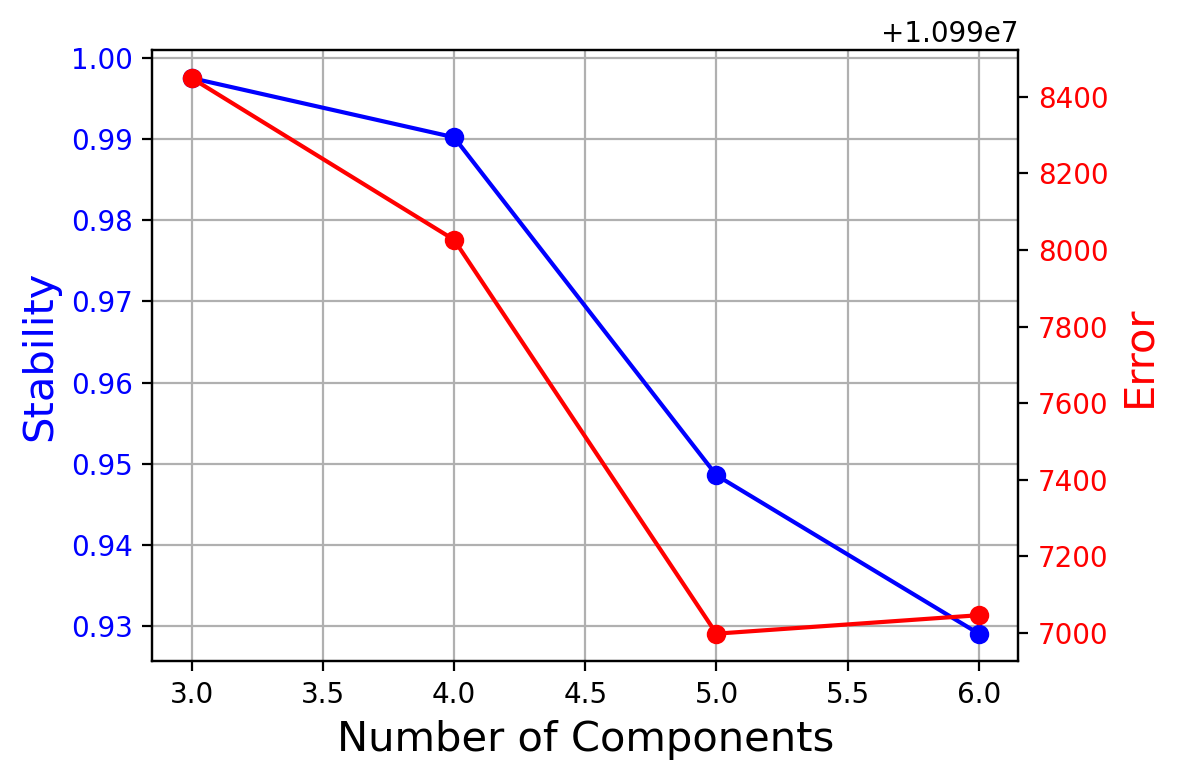

In [30]:
cnmf_obj.k_selection_plot(close_fig=False)

In [ ]:
print('This saves the corresponding figure to the following file: %s' % cnmf_obj.paths['k_selection_plot'])

In [11]:
selected_K = 4
density_threshold = 2.00

/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


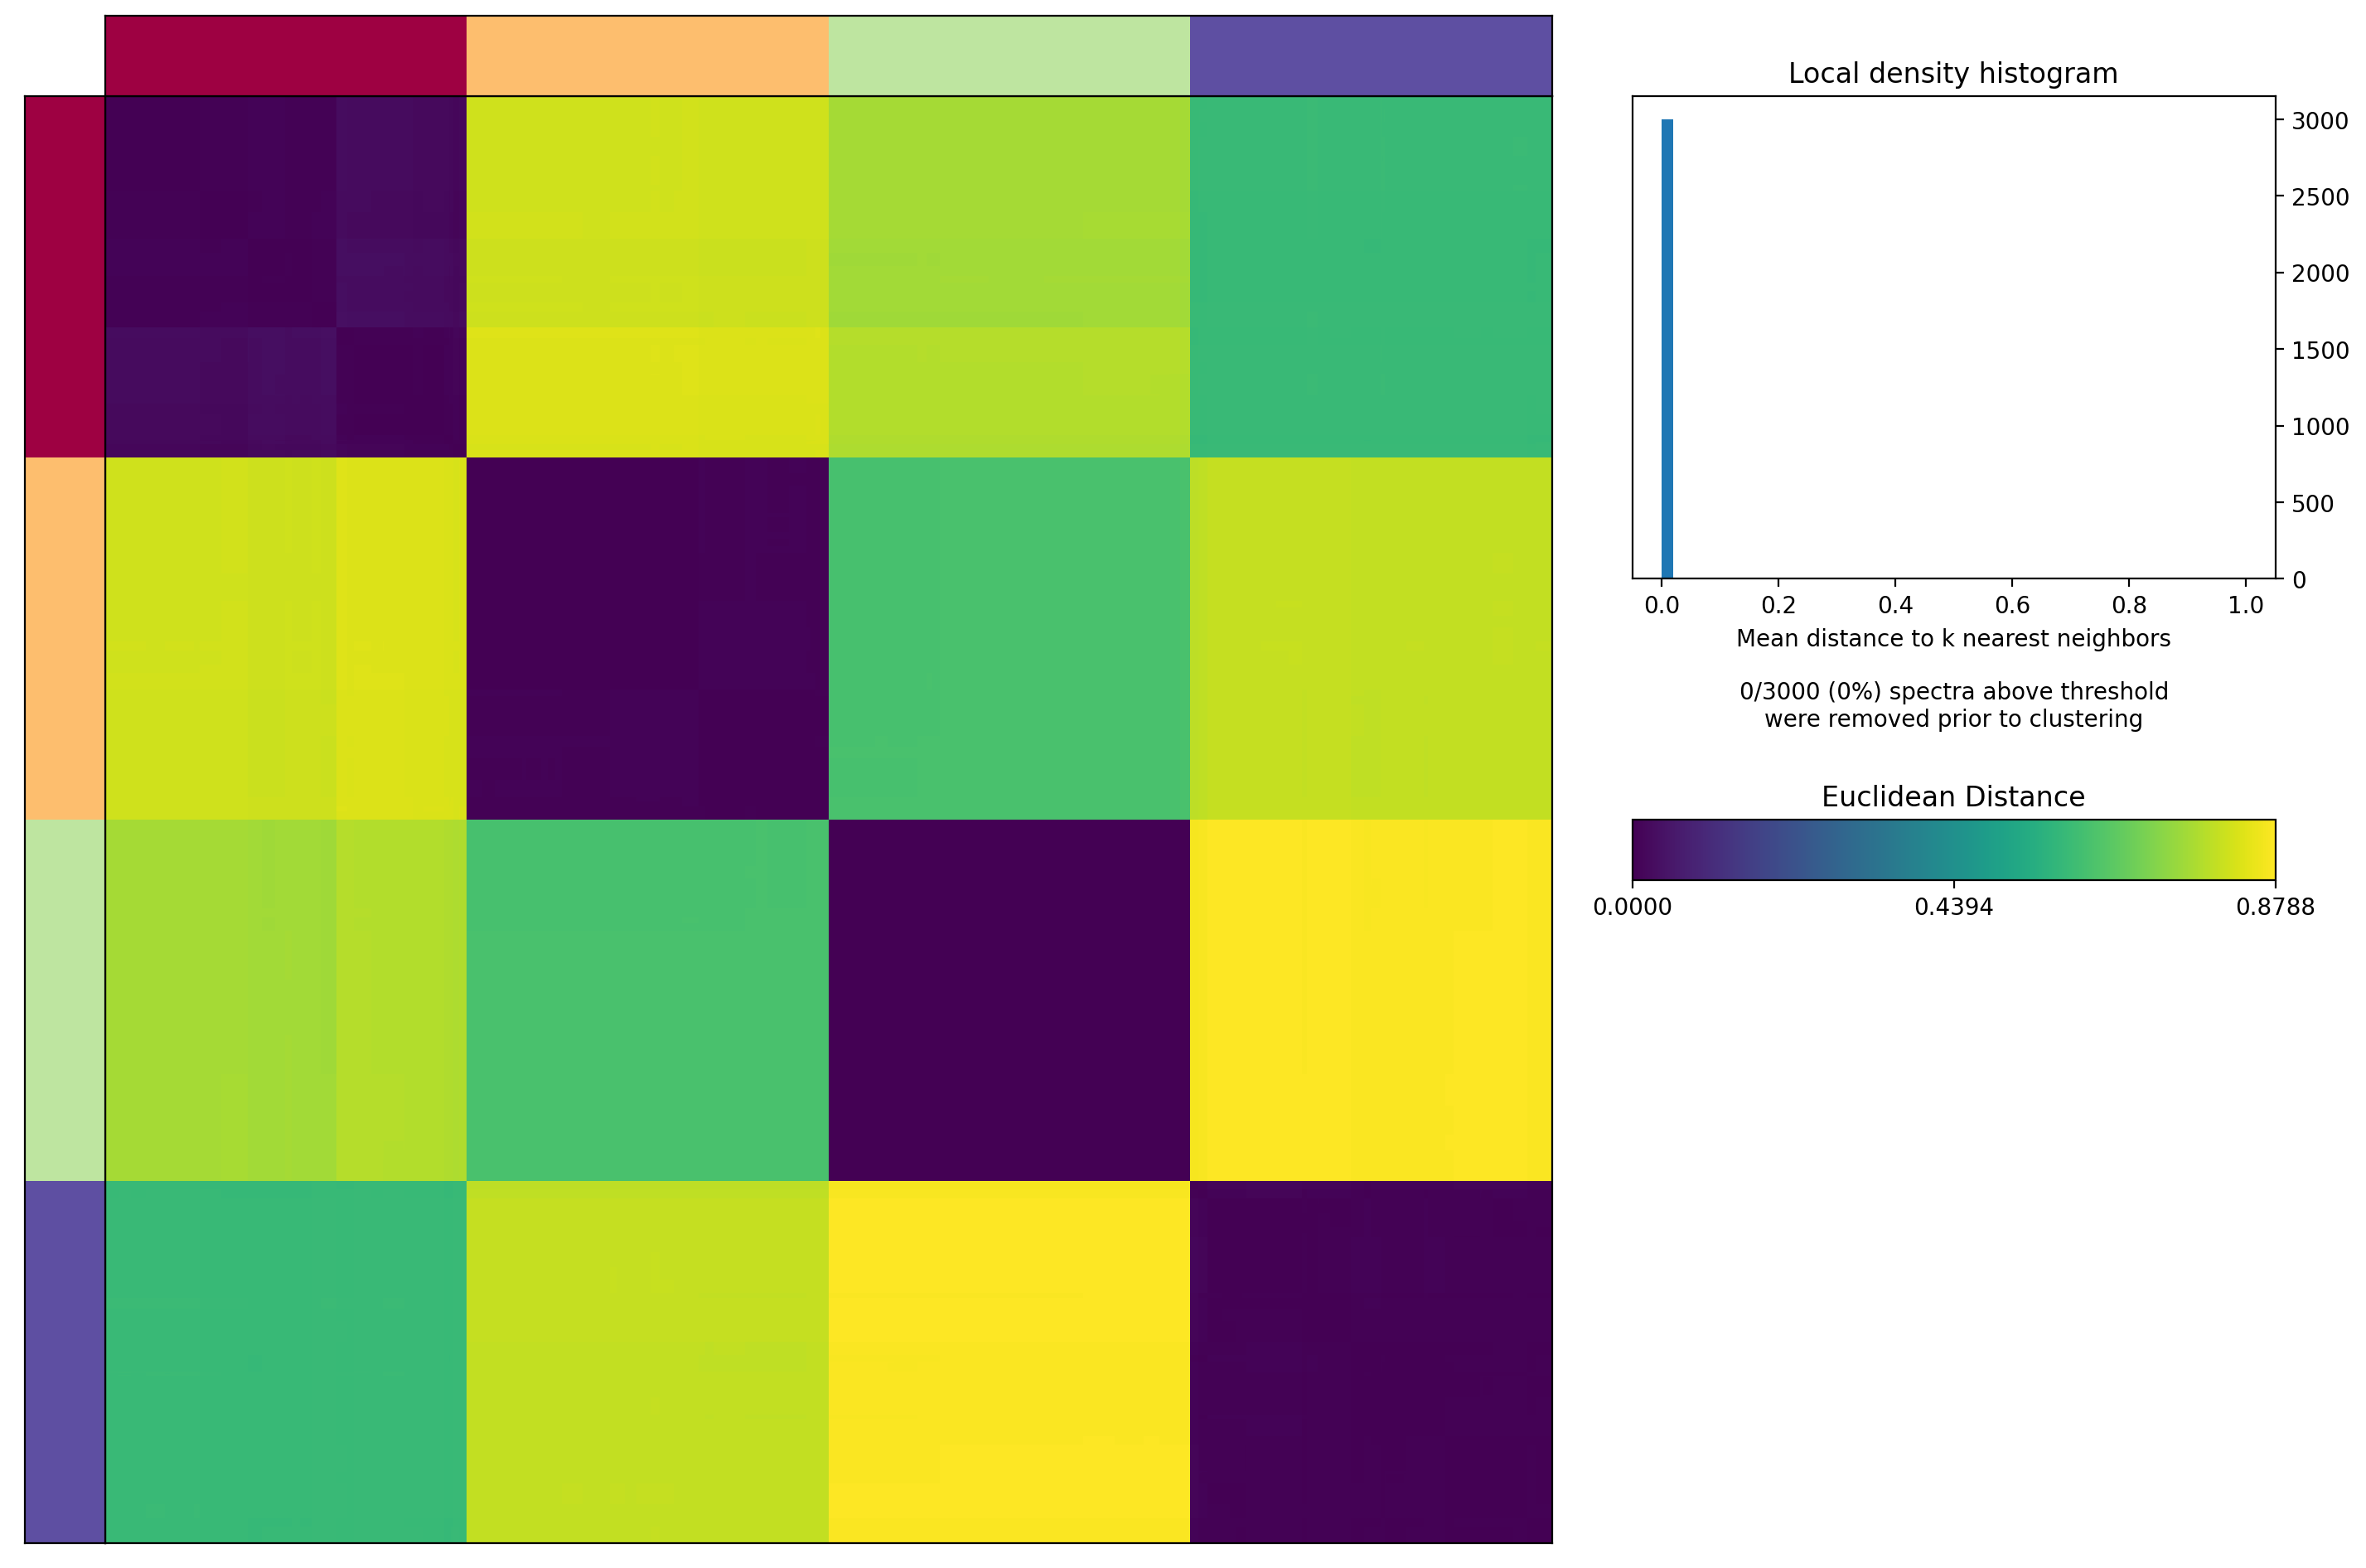

In [39]:
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False, refit_usage=False)

In [33]:
adata = sc.read(countfn)

adata.obsm['X_pca'] = np.empty([adata.shape[0], 2])
adata.obsm['X_pca'][:,0] = adata.obs['PC_1']
adata.obsm['X_pca'][:,1] = adata.obs['PC_2']

/root/miniconda/envs/NMF_indNeuro/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Directory to save results 

In [34]:
save_dir = output_directory+"/"+run_name

In [4]:
hvgs = open('/home/jovyan/jm_jlab/jm_2023/combined-all_to_oRG//combined-all_to_oRG/combined-all_to_oRG.overdispersed_genes.txt').read().split('\n')

In [12]:
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)
usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]

In [13]:
print("Number of HVGs used: %d" %len(hvgs))
print("Number of genes per module: %d " %topgenes.shape[0])

Number of HVGs used: 4000
Number of genes per module: 100 


<AxesSubplot:xlabel='t'>

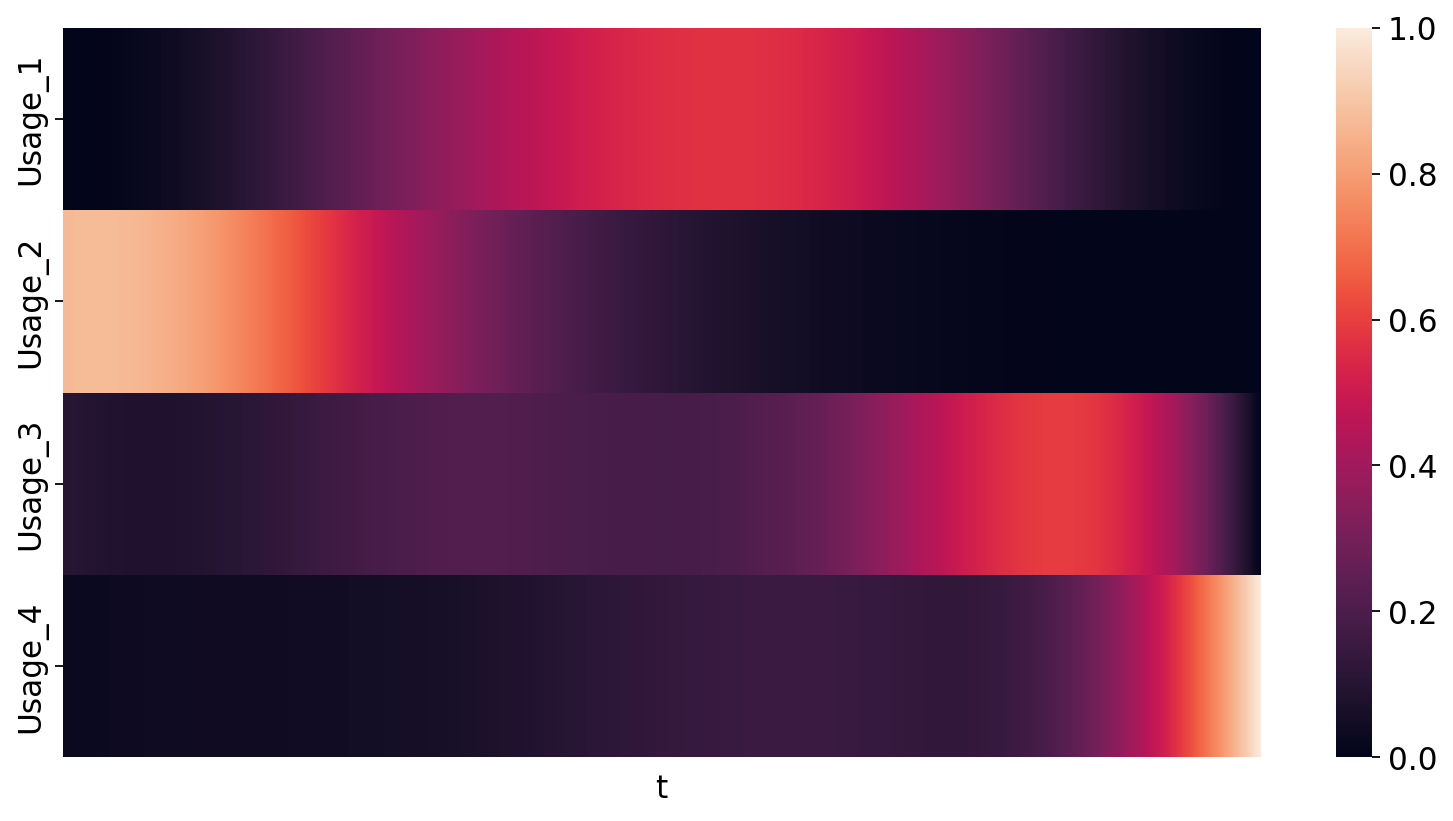

In [14]:
sc.set_figure_params(figsize=(12,6))

sns.heatmap(usage_norm.transpose(), xticklabels=False, yticklabels=True)

In [15]:
#For pseudotemporal ordering in heatmap
usage_norm.rename(columns={'Usage_1':"Module_2", 'Usage_2':"Module_1", 'Usage_3':"Module_3", 'Usage_4':"Module_4"}, inplace=True)
topgenes.rename(columns={1:"Module_2", 2:"Module_1", 3:"Module_3", 4:"Module_4"}, inplace=True)

In [16]:
usage_norm = usage_norm[['Module_1','Module_2','Module_3','Module_4']]
topgenes = topgenes[['Module_1','Module_2','Module_3','Module_4']]

[Text(0.5, 63.666666666666686, 'pseudotime')]

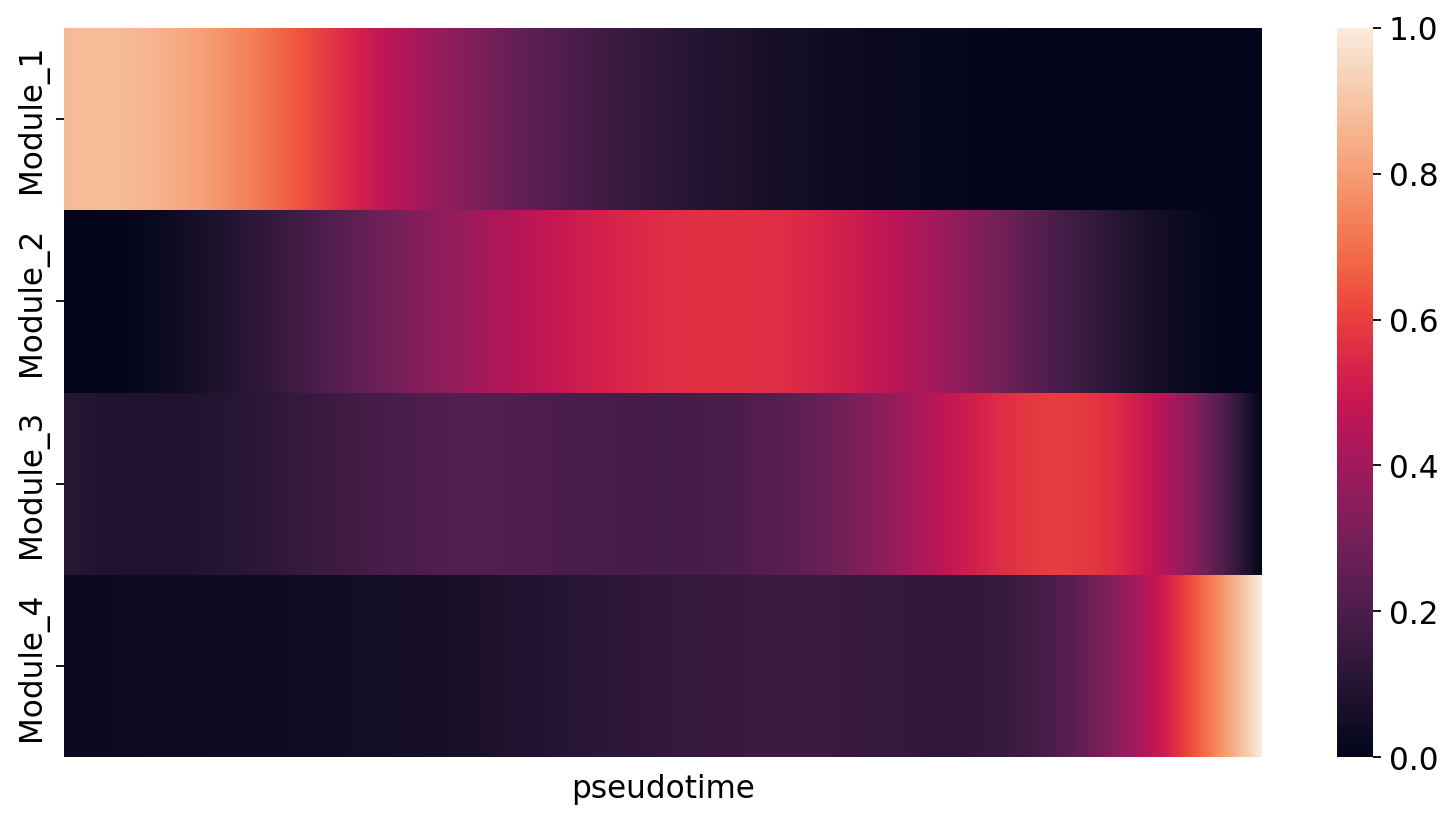

In [17]:
sc.set_figure_params(figsize=(12,6))

pl1 = sns.heatmap(usage_norm.transpose(), xticklabels=False, yticklabels=True)
pl1.set(xlabel="pseudotime") 

In [22]:
topgenes.to_csv(save_dir+"/combined-all_to_oRG_4K_piNMF.tsv", sep='\t', index=False, header=True)

In [23]:
usage_norm.to_csv(save_dir+'combined-all_to_oRG_4K_piNMF.tsv', sep='\t', index=False, header=True)

### Perform enrichment analyses via GProfiler 

In [7]:
from gprofiler import GProfiler

In [24]:
gp = GProfiler(return_dataframe=True)

In [25]:
for j in topgenes.columns:
    
    print("")

    print("GO analysis for %s" %j)
    tmp = gp.profile(organism='hsapiens', 
               query=topgenes[j].tolist(), no_evidences=False)
    for i in tmp['source'].value_counts().index:
        if ("GO" not in i) and ("TF" not in i):
            print(i+"____")
            print(tmp[tmp['source'] == i]['name'])


GO analysis for Module_1
HP____
78                                  Leber optic atrophy
103                         Retinal arterial tortuosity
104          Central retinal vessel vascular tortuosity
115                                 Centrocecal scotoma
147                           Mitochondrial inheritance
167    Segmental peripheral demyelination/remyelination
186             Mitochondrial respiratory chain defects
220                            Peripheral demyelination
234                 Increased CSF protein concentration
243                                   Episodic vomiting
247                  Abnormal CSF protein concentration
253                            Ragged-red muscle fibers
254                              Mitochondrial myopathy
259                              Retinal telangiectasia
260                                 Arterial tortuosity
276                           Multiple glomerular cysts
277                           Ventricular preexcitation
295            

In [26]:
writer = pd.ExcelWriter(save_dir+"/combined-all_to_oRG_4K_GOenrich_piNMF.xlsx", engine='xlsxwriter')

for j in topgenes.columns:

    print("%s" %j)
    
    tmp = gp.profile(organism='hsapiens', 
               query=topgenes[j].tolist(), no_evidences=False)
    tmp.to_excel(writer, sheet_name=str(j))

writer.close()

Module_1
Module_2
Module_3
Module_4


# Similar to IP branch

In [ ]:
adata = sc.read_h5ad("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/combined_count_all.h5ad")

In [ ]:
milestones = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/scFates_output/combined_all_scFates_clustering.tsv", sep='\t', index_col=0)

In [ ]:
adata.obs = pd.concat([adata.obs, milestones], axis=1)

In [ ]:
cellembeddings = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/combined_all_cellembeddings.tsv", sep='\t')

In [ ]:
cellembeddings.iloc[:,0] = cellembeddings.iloc[:,0]*-1 #for better geometry
cellembeddings.iloc[:,1] = cellembeddings.iloc[:,1]*-1 #for better geometry

In [ ]:
adata.obsm['X_pca'] = cellembeddings.to_numpy() #sharing embeddings

In [ ]:
adata.obs['PC_1'] = adata.obsm['X_pca'][:,0]
adata.obs['PC_2'] = adata.obsm['X_pca'][:,1]

In [ ]:
sc.pl.pca(adata, color = 'milestones')

In [ ]:
#IP: 3 and 2
branch_IP = adata[(adata.obs['seg'] == 3) | (adata.obs['seg'] == 1),:]

In [ ]:
sc.pp.filter_genes(branch_IP, min_cells=25)

sc.pp.highly_variable_genes(branch_IP, n_top_genes=4000, flavor='seurat_v3')

branch_IP = branch_IP[:,branch_IP.var['highly_variable'] == True].copy()

my_data = pd.DataFrame(branch_IP.X.todense(), index=branch_IP.obs['t'], columns=branch_IP.var_names)

my_data.sort_index(inplace=True, ascending=True)

for_NMF = sc.AnnData(my_data)

for_NMF

branch_IP.obs.index = branch_IP.obs['t'].astype(np.float64)

branch_IP.obs = branch_IP.obs.reindex(np.sort(branch_IP.obs.index))

for_NMF.obs.index = for_NMF.obs.index.astype(np.float64)

for_NMF.obs = for_NMF.obs.join(branch_IP.obs)

In [ ]:
for_NMF.write("/home/jovyan/jm_jlab/data_indNeuro/2.NMF/combined-all_vRGtoIP_4k.h5ad")

In [ ]:
numiter=  750 # Number of NMF replicates. Recommended ~200 for real data
numhvgenes= 4000 

countfn = '/home/jovyan/jm_jlab/data_indNeuro/2.NMF/combined-all_vRGtoIP_4k.h5ad'

## Results will be saved to [output_directory]/[run_name]
output_directory = '/home/jovyan/jm_jlab/jm_2023/combined-all_to_IP/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'combined-all_to_IP'

seed = 14

In [ ]:
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [ ]:
cnmf_obj.prepare(counts_fn=countfn, components=np.arange(3,7), n_iter=numiter, seed=seed, num_highvar_genes=numhvgenes)

In [ ]:
cnmf_obj.factorize(worker_i=0, total_workers=1)

In [ ]:
cnmf_obj.combine(skip_missing_files=True)

In [ ]:
cnmf_obj.k_selection_plot(close_fig=False)

In [ ]:
print('This saves the corresponding figure to the following file: %s' % cnmf_obj.paths['k_selection_plot'])

In [ ]:
selected_K = 4
density_threshold = 2.00

In [ ]:
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False, refit_usage=False)

In [ ]:
adata = sc.read(countfn)

adata.obsm['X_pca'] = np.empty([adata.shape[0], 2])
adata.obsm['X_pca'][:,0] = adata.obs['PC_1']
adata.obsm['X_pca'][:,1] = adata.obs['PC_2']

In [ ]:
save_dir = output_directory+"/"+run_name

In [ ]:
save_dir

In [ ]:
output_directory

In [ ]:
!ls /home/jovyan/jm_jlab/jm_2023/test_data/test_data/test_data.overdispersed_genes.txt

In [ ]:
hvgs = open('/home/jovyan/jm_jlab/jm_2023/combined-all_to_IP//combined-all_to_IP/combined-all_to_IP.overdispersed_genes.txt').read().split('\n')

In [ ]:
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)
usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]

In [ ]:
print("Number of HVGs used: %d" %len(hvgs))
print("Number of genes per module: %d " %topgenes.shape[0])

In [ ]:
sc.set_figure_params(figsize=(12,6))

sns.heatmap(usage_norm.transpose(), xticklabels=False, yticklabels=True)

In [ ]:
#For pseudotemporal ordering in heatmap
usage_norm.rename(columns={'Usage_1':"Module_2", 'Usage_2':"Module_3", 'Usage_3':"Module_1", 'Usage_4':"Module_4"}, inplace=True)
topgenes.rename(columns={1:"Module_2", 2:"Module_3", 3:"Module_1", 4:"Module_4"}, inplace=True)

In [ ]:
usage_norm = usage_norm[['Module_1','Module_2','Module_3','Module_4']]
topgenes = topgenes[['Module_1','Module_2','Module_3','Module_4']]

In [ ]:
sc.set_figure_params(figsize=(12,6))

pl1 = sns.heatmap(usage_norm.transpose(), xticklabels=False, yticklabels=True)
pl1.set(xlabel="pseudotime") 

In [ ]:
topgenes.head()

In [ ]:
save_dir = output_directory+"/"+run_name

In [ ]:
save_dir

In [ ]:
topgenes.to_csv(save_dir+"/combined-all_to_IP_4K_piNMF.tsv", sep='\t', index=False, header=True)

In [ ]:
usage_norm.to_csv(save_dir+'combined-all_to_IP_4K_piNMF.tsv', sep='\t', index=False, header=True)

In [ ]:
from gprofiler import GProfiler

In [ ]:
gp = GProfiler(return_dataframe=True)

In [ ]:
for j in topgenes.columns:
    
    print("")

    print("GO analysis for %s" %j)
    tmp = gp.profile(organism='hsapiens', 
               query=topgenes[j].tolist(), no_evidences=False)
    for i in tmp['source'].value_counts().index:
        if ("GO" not in i) and ("TF" not in i):
            print(i+"____")
            print(tmp[tmp['source'] == i]['name'])

In [ ]:
writer = pd.ExcelWriter(save_dir+"/combined-all_to_IP_4K_GOenrich_piNMF.xlsx", engine='xlsxwriter')

for j in topgenes.columns:

    print("%s" %j)
    
    tmp = gp.profile(organism='hsapiens', 
               query=topgenes[j].tolist(), no_evidences=False)
    tmp.to_excel(writer, sheet_name=str(j))

writer.close()